# Topographic Controls on Supraglacial Meltwater Drainage Systems on Antarctic Ice Shelves.

## Julian Spergel, Jonathan Kingslake
### Topographic Controls on Supraglacial Meltwater Drainage Systems on Antarctic Ice Shelves.

#### 1. Import the necessary Python packages:

In [1]:
from dask.diagnostics import ProgressBar
import dask
import dask.delayed
import numpy as np
import xarray as xr
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.image as mplimage
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
%matplotlib inline
import sklearn.linear_model
import skimage.morphology
import skimage.segmentation
#import richdem as rd
import scipy.ndimage
import dask
import math
import scipy.sparse
import shapefile
import shapely
import os
import dask
import dask.array as da
import pandas as pd

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

<ipython-input-1-3d631fdd86e8>:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### 2. We have translated a number of functions to calculate hydrology catchment divides from Matlab's TopoToolbox (2014) 

In [2]:
import HydrologyFunctions as hy

### 3. Below we load a map of ice shelf locations from the NSIDC website:

Text(0.5, 1.0, 'https://nsidc.org/sites/nsidc.org/files/images/iceshelf_locations.png')

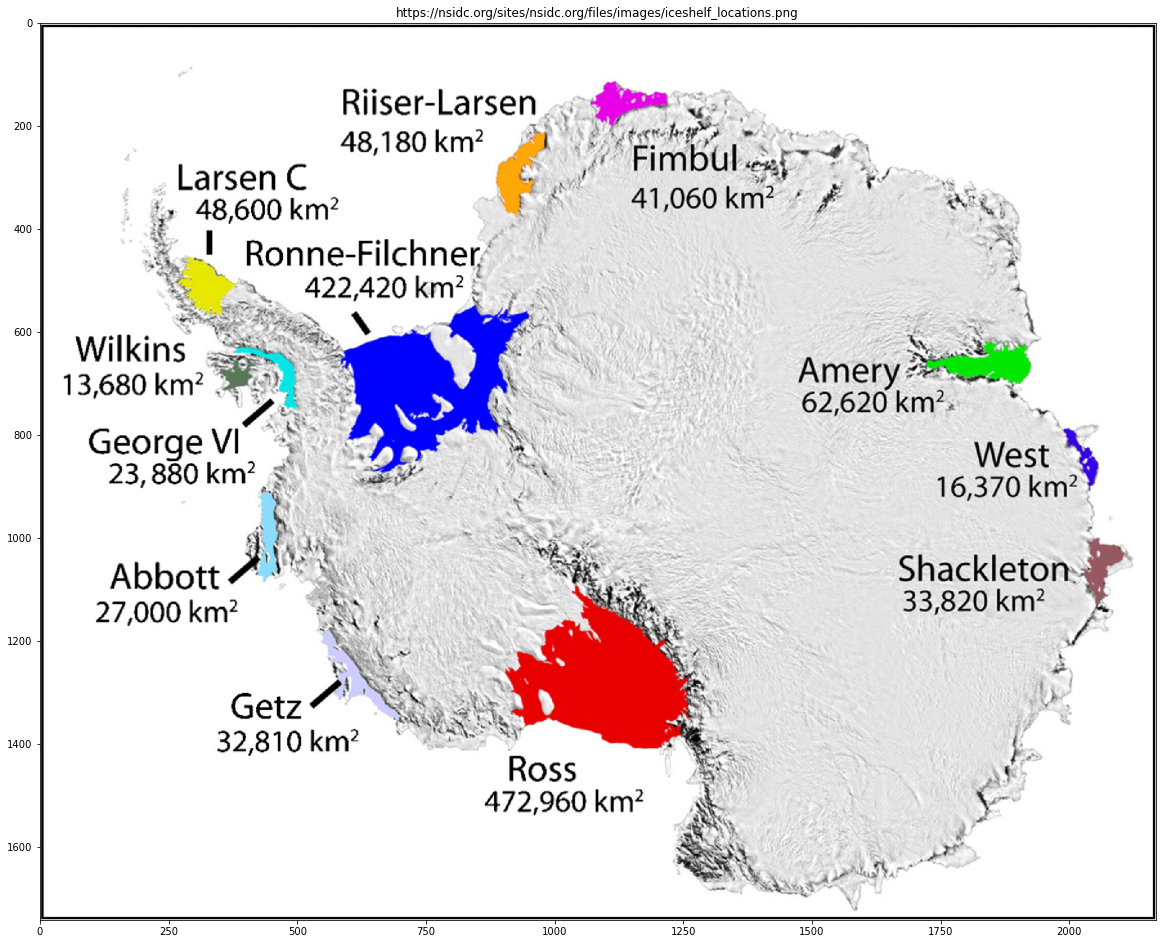

In [3]:
image = mplimage.imread('https://nsidc.org/sites/nsidc.org/files/images//iceshelf_locations.png')
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.title('https://nsidc.org/sites/nsidc.org/files/images/iceshelf_locations.png')

### 4. read in the shapefiles of ice shelf grounding lines, then read in the REMA tile index

In [5]:
IS = gpd.read_file('IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 
REMA_index = gpd.read_file('REMA_Tile_Index/REMA_Tile_Index_Rel1_1.shp')

In [6]:
def f(shelf):#select an ice shelf, the Amery Ice Shelf in east Antarctica
    SelectedIceShelf = IS[IS.NAME==shelf]
    fig,axis = plt.subplots()
    REMA_index.plot(ax=axis)
    SelectedIceShelf.geometry.plot(ax=axis,color='r')

w = interactive(f,shelf = list(IS.NAME))

## 5. Please select an ice shelf from the drop-down menu below:
#### **Large ice shelves will take longer to load.

In [7]:
display(w)

interactive(children=(Dropdown(description='shelf', options=('Dawson_Lambton', 'Philbin_Inlet', 'Walgreen_Coas…

### 6. Download the files from a Google Bucket. This code go to our cloud optimized geotiff version of the REMA stored in the google cloud and downloads the tiles we chose by geographically subsetting by the area chosen above. (1-2 min)


In [8]:
sample = hy.download_REMA(w.kwargs['shelf']) #we download only half of the ice shelf for a faster experiience

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


## 7. Plot an elevation map of the selected ice shelf. Here we simply load the data lazily, coarsen it to a coaser resolution (for faster plotting),  and add in the ice shelve's grounding line in red. (2-5min):

[                                        ] | 2% Completed | 12.2s

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  7min 25.7s


<AxesSubplot:title={'center':'band = 1'}, xlabel='x', ylabel='y'>

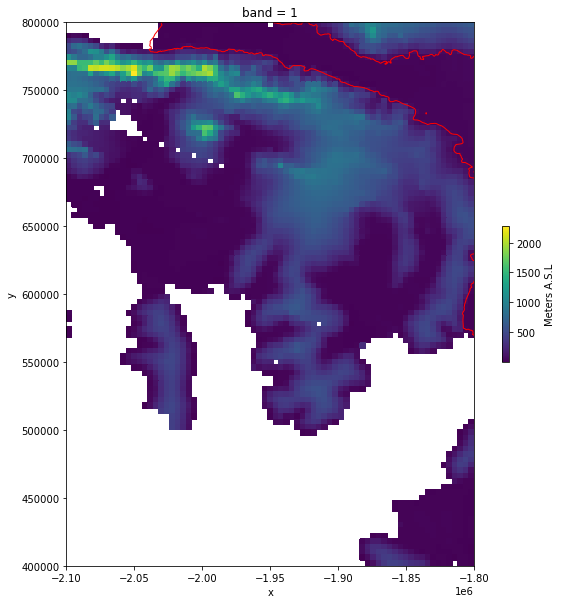

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
with ProgressBar():
    dem_plot = sample.coarsen(x=5,y=5).mean().plot(ax=ax,add_colorbar=False)
plt.colorbar(dem_plot, shrink=0.25, label='Meters A.S.L')
SelectedIceShelf = IS[IS.NAME==w.kwargs['shelf']]
SelectedIceShelf.plot(ax=ax, facecolor='None',edgecolor='r')

In [10]:
#Normally we'd test to see if there is missing data, but for this sample notebook, we'll assume that yes, there is missing data. 
flag_nans = True 

### 8. Calculating the  drainage basins requires a preliminary pre-processing step in which we find the DEM's local minima, maxima, and isolated catchments. Here we calculate the "flats","sills",and "interior basins" in the digital elevation model, using dask to calculate over smaller chunks of the data. 

In [11]:
identified_flats = sample.data.map_blocks(hy.identifyflats, dtype=float)
identified_sills = dask.array.map_blocks(lambda dem,flats: hy.identifysills(dem,flats), sample.data, identified_flats, dtype=float)
identified_interbasins = sample.data.map_overlap(lambda dem: hy.identifyinteriorbasins(dem), depth=1, dtype=float)
cellsize = 8*100*8*100
FlowObj_dask = lambda dem,flats,sills,interiorbasins: hy.drainagebasins(dem,flats,sills,interiorbasins,cellsize)

### 9. Using these calculations, we are able to calculate the drainage catchment separations using TopoToolbox's FlowObj() function,translated from the Matlab function of the same name. (3-5 min):  

[                                        ] | 1% Completed |  1.0s

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[####################################### ] | 99% Completed |  4min 43.6s

/home/jovyan/REMAWaterRouting/HydrologyFunctions.py:396: RuntimeWarning: invalid value encountered in subtract
  D = ((skimage.morphology.reconstruction(seed = D+1,mask=masked,method='erosion'))- D) *cellsize
/home/jovyan/REMAWaterRouting/HydrologyFunctions.py:401: RuntimeWarning: divide by zero encountered in reciprocal
  cost_field  = map_image_to_costs(D**-1,PreSillPixel)
/home/jovyan/REMAWaterRouting/HydrologyFunctions.py:163: RuntimeWarning: invalid value encountered in subtract
  G = (D-np.min(D))/(np.max(D)-np.min(D))**-1
/home/jovyan/REMAWaterRouting/HydrologyFunctions.py:163: RuntimeWarning: invalid value encountered in double_scalars
  G = (D-np.min(D))/(np.max(D)-np.min(D))**-1
/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/lib/function_base.py:1280: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


[########################################] | 100% Completed |  4min 44.2s


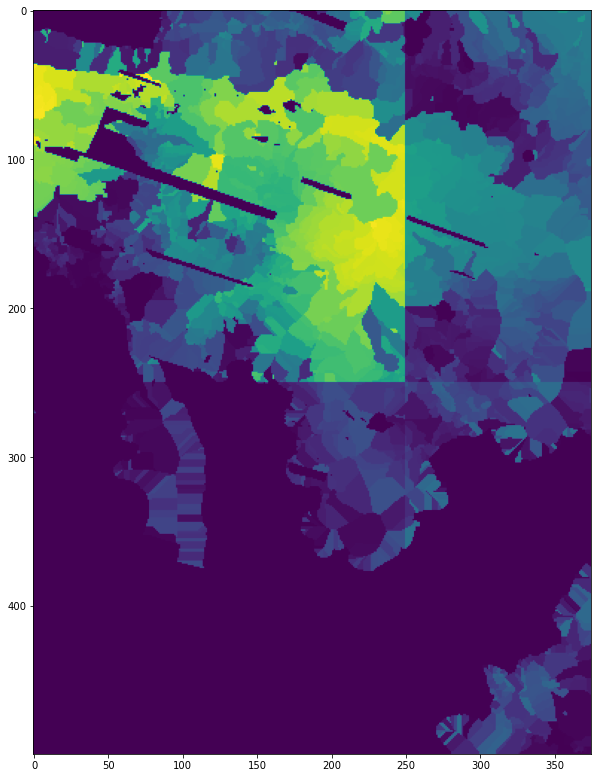

In [12]:
FlowObj_values = dask.array.map_overlap(FlowObj_dask,sample.data,identified_flats,identified_sills,identified_interbasins,dtype=float, depth=10, align_arrays=True)
with ProgressBar():
    DB = FlowObj_values.compute()
plt.figure(figsize=(10,20))
plt.imshow(DB)

###  10. To remove the gridlines from the drainage catchment boundaries, we do a simple clean-up. This assumes that none of the gridlines contain a segment of a real catchment separation (<1min):

In [13]:
def cleandrainagebasins(D):
    D_labelled = skimage.morphology.label(D)

    D_labelled_new = D

    #merge down
    for i in np.arange(250,D.shape[0]-1,250):
        topside = D[i-1,:]
        topside_values = np.argwhere(np.diff(topside)!=0)
        for ii in np.arange(0,len(topside_values)):
            col_to_merge = topside_values[ii]
            basin_to_merge = D_labelled[i,col_to_merge]
            mask_right = np.argwhere(D_labelled == basin_to_merge)
            [mask_x,mask_y] = np.array(mask_right).T
            D_labelled_new[mask_x,mask_y] = D[i-1,topside_values[ii]]

    #Merge left
    for i in np.arange(250,D.shape[1],250):
        leftside = D_labelled[:,i-1]
        leftside_values = np.argwhere(np.diff(leftside)!=0)
        for ii in np.arange(0,len(leftside_values)):
            row_to_merge = leftside_values[ii]
            basin_to_merge = D_labelled[row_to_merge,i]
            D_labelled_new[D_labelled == basin_to_merge] = D[leftside_values[ii],i-1]

    xarray_D = xr.DataArray(data = D_labelled_new, coords = sample.coords,dims = sample.dims, attrs = sample.attrs)
    return xarray_D

<AxesSubplot:title={'center':'band = 1'}, xlabel='x', ylabel='y'>

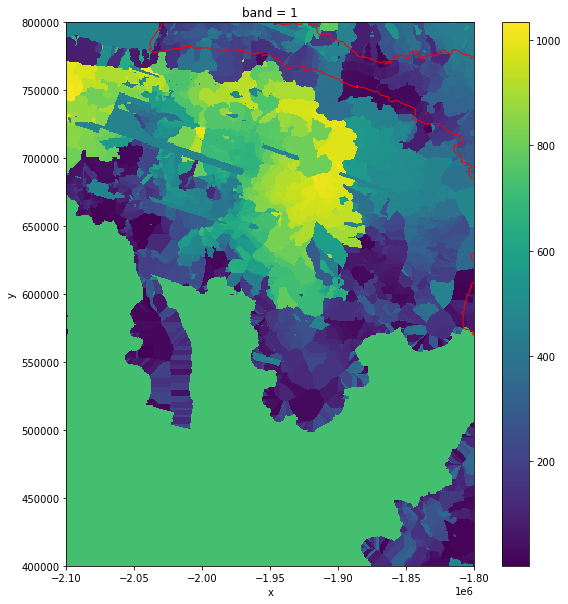

In [29]:
with ProgressBar():
    D_new = cleandrainagebasins(DB)
fig, ax = plt.subplots(figsize=(10,10))
D_new.plot(ax=ax)
SelectedIceShelf = IS[IS.NAME==w.kwargs['shelf']]
SelectedIceShelf.plot(ax=ax, facecolor='None',edgecolor='r')

## 11. Calculating the depth of surface depressions. We use a simple image reconstruction method to find the depths of depressions relative to their immediate surroundings. This is a translation of TopoToolbox's "fillsinks" function.(5-10 min):

In [15]:
def filledbasins(dem):
    Inans = dask.array.isnan(dem)
    dem_nonans =  dem.fillna(-np.inf)
    marker = np.negative(dem_nonans);
    #dem = dem + np.multiply(Inans,-np.inf)
    II = np.zeros(dem.shape);
    II[1:-1,1:-1] = 1;
    mask = np.bitwise_and(np.bool_(II),~Inans)*-np.inf
    marker = marker+mask;
    demfs = -skimage.morphology.reconstruction(marker,-dem_nonans, method='dilation')
    return demfs

demfs_task = lambda dem: filledbasins(dem)
with ProgressBar():
    demfs = dask.array.map_blocks(demfs_task, dem=sample, dtype=float)

[########################################] | 100% Completed |  2min  0.5s
[####################################### ] | 99% Completed |  2min  0.7s


In [16]:
with ProgressBar():
    demfs = demfs.persist()

[                                        ] | 1% Completed |  0.9s

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  4min 23.5s


In [17]:
with ProgressBar():
    demfs = demfs.compute()

[########################################] | 100% Completed |  0.1s


In [18]:
depths = dask.array.subtract(demfs,sample.data)

In [19]:
depths

dask.array<subtract, shape=(500, 375), dtype=float64, chunksize=(250, 250), chunktype=numpy.ndarray>

In [20]:
with ProgressBar():
    Depths = depths.compute()

[                                        ] | 2% Completed |  4.8s

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  4min 22.0s


In [21]:
Depths_Array = sample
Depths_Array.data = Depths

<AxesSubplot:title={'center':'band = 1'}, xlabel='x', ylabel='y'>

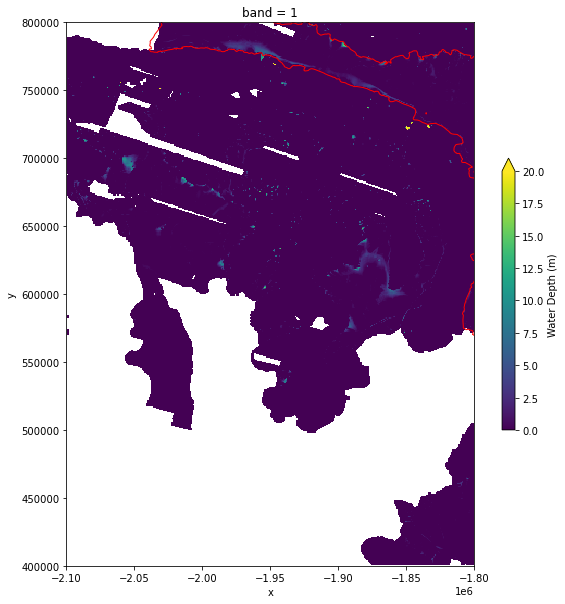

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
depthplot = Depths_Array.plot(ax=ax,vmax=20,add_colorbar=False)
plt.colorbar(depthplot,label='Water Depth (m)', shrink=0.5, extend='max')
SelectedIceShelf.plot(ax=ax, facecolor='None',edgecolor='r')

## 12. With both the catchment boundaries and the depression depths, we can calculate the statistics of the drainage catchments. First we can create a Pandas dataframe with all of the catchment information (<1 min)

In [30]:
with ProgressBar():
    #Build  data structure  on each drainage Catchments

    b_dict = {'CatchmentNumber','CatchmentArea','MaskLogical','MaskI','MaskXY','skip','Volume','maxdepth','hw','h','p'}
    b = pd.DataFrame(data={},columns=b_dict)

    histcount = np.bincount(D_new.data.ravel())
    catchment_num = np.max(D_new.data.ravel())
    valid_catchment= []
    for kk in np.arange(0,catchment_num):
        CatchmentNumber = kk;
        Mask = D_new.data == kk; 
        CatchmentArea = (np.sum(np.int_(Mask.ravel()))*cellsize); # basin area in m^2
        if CatchmentArea>0:
            valid_catchment = np.append(valid_catchment,kk)


    for catchment in valid_catchment:
        CatchmentNumber = catchment;
        Mask = D_new.data == catchment; 
        CatchmentArea = (np.sum(np.int_(Mask.ravel()))*cellsize); # basin area in m^2
        MaskLogical = Mask;
        MaskXY = np.where(Mask);  # mask for the basin
        MaskI= np.ravel_multi_index(MaskXY,sample.shape)
        depths = Depths_Array.data[MaskXY] #Water accomodation space in drainage basin
        if np.count_nonzero(depths>0)<4: #If accomodation space is zero, i.e, no nonzero depths
            skip = 1;
            h = 0;
            maxdepth = 0;
            Volume = 0;
            hw = np.zeros(depths.size)
            continue
        else:
            valid = np.argwhere(depths>=0)
            depths = depths[valid];
            heights = np.max(depths) - depths; #potential water height from bottom
            skip = 0;        
            Volume = (np.sum(depths.ravel())*cellsize);
            heights_sorted = np.sort(list(heights.flatten()));
            while len(np.argwhere(np.diff(heights_sorted)==0))>0: #remove all identical pixels
                I = np.argwhere(np.diff(heights_sorted)==0);
                heights_sorted[I+1] = heights_sorted[I+1] +0.0001; # nudge the similar values up a tiny amount to avoid issues with the interpolation
            hw = heights_sorted;   # heights for hypsometry
            maxdepth = np.max(depths); # not actually the same as max(Heights) the smallest value of depths is not equal to demero
            h = 0;   # initial water depth is demero
            volume = np.zeros((len(heights)-1,1));
            if np.count_nonzero(depths)>5:
                totalVolume = Volume;
                for i in np.arange(0,len(heights)-1):
                    volume[i] = (volume[i-1]+ (hw[i+1]-hw[i])*(i*cellsize));

                Y = (np.log(volume/totalVolume));
                X  = list(np.log(hw[0:-1]/maxdepth)),
                X = X[0]
                X.pop(0)
                Y = list(Y.flatten())
                Y.pop(0)
                reg = np.polyfit(list(X),list(Y),1)

                p = reg[0];
            else:
                p = 1;
        data={'CatchmentNumber':CatchmentNumber,
               'CatchmentArea':CatchmentArea,
               'MaskLogical':MaskLogical.ravel(),
               'MaskI':MaskI,
                'MaskXY': MaskXY,
               'skip':skip,
               'Volume':Volume,
               'maxdepth':maxdepth,
               'hw':hw,
               'h':h,
               'p':p
                }
        DrainageBasin = pd.Series(data)
    #else:
        #continue
        b = b.append(DrainageBasin, ignore_index=True)

<ipython-input-30-fb970d812eb0>:52: RuntimeWarning: divide by zero encountered in log
  Y = (np.log(volume/totalVolume));
<ipython-input-30-fb970d812eb0>:53: RuntimeWarning: divide by zero encountered in log
  X  = list(np.log(hw[0:-1]/maxdepth)),


### 12a. Here we calculate the hypsometry coefficient, p, of each basin. p=1 when the basin is square bottomed, p=2 when the basin is a soup-bowl shape, and p>3 when the basin is conical with increasing sharpness as p increases.

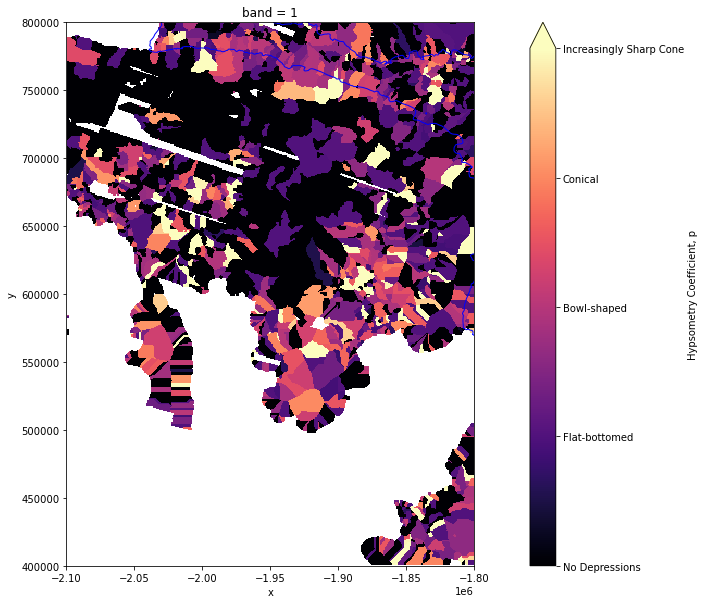

In [31]:
p_map = np.zeros(Depths_Array.shape)

for c in np.arange(0,len(b)):
    p_map[b['MaskXY'][c]] = b['p'][c]*np.ones((1,len(b['MaskI'][c])))

Pmap = D_new
nan_mask = np.ones(D_new.shape)
nan_mask[np.isnan(sample)] = np.nan
Pmap.data = p_map*nan_mask


fig, ax = plt.subplots(figsize=(20,10))
pplot = Pmap.plot(ax=ax,vmax=4,cmap='magma',add_colorbar=False)
SelectedIceShelf.plot(ax=ax, facecolor='None',edgecolor='b')
cbar = plt.colorbar(pplot,label='Hypsometry Coefficient, p',ticks=[0,1,2,3,4],extend='max')
cbar.ax.set_yticklabels(['No Depressions','Flat-bottomed','Bowl-shaped','Conical','Increasingly Sharp Cone']);


### 12b. Here we calculate the ratio of Basin Volume to  Catchment Area.

<AxesSubplot:title={'center':'band = 1'}, xlabel='x', ylabel='y'>

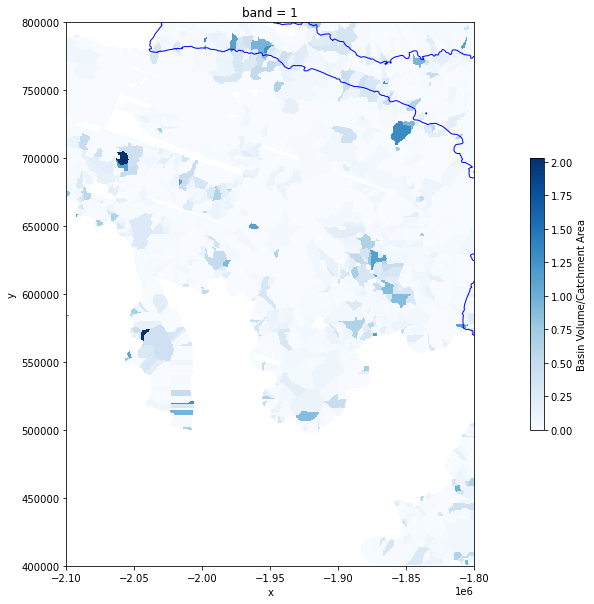

In [32]:
ratio_map = np.zeros(Depths_Array.shape)

for c in np.arange(0,len(b)):
    ratio_map[b['MaskXY'][c]] = (b['Volume'][c]/b['CatchmentArea'][c])*np.ones((1,len(b['MaskI'][c])))

ratiomap = D_new
ratiomap.data = ratio_map*nan_mask

fig, ax = plt.subplots(figsize=(20,10))

ratioplot = ratiomap.plot(ax=ax,cmap='Blues', cbar_kwargs={'shrink':0.5,'label':'Basin Volume/Catchment Area'})
SelectedIceShelf.plot(ax=ax, facecolor='None',edgecolor='b')
#plt.title('Basin Volume/Catchment Area')